In [ ]:
pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in e:\anaconda3\lib\site-packages (2.2.0)Note: you may need to restart the kernel to use updated packages.



In [ ]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.tokenize import word_tokenize
import re
from sklearn.preprocessing import LabelEncoder
import spacy
from spacy.tokenizer import Tokenizer
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from torchviz import make_dot

In [ ]:
device = 'cuda'

In [ ]:
data_labels = pd.read_csv('labels.csv')
data_labels = data_labels.dropna()
data_labels = data_labels.reset_index()

In [ ]:
data_labels

,index,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral
...,...,...,...,...,...,...,...,...,...,...
6825,6987,6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,Tuesday is Mardi Gras Wednesday is Valentine's...,very_funny,twisted_meaning,very_offensive,motivational,neutral
6826,6988,6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,funny,twisted_meaning,not_offensive,not_motivational,neutral
6827,6989,6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,funny,general,slight,not_motivational,positive
6828,6990,6990,image_6991.jpg,When I VERY have time is a fantasy No one has ...,When I have time is a fantasy. no one has time...,not_funny,twisted_meaning,not_offensive,motivational,very_positive


#  Preprocessing and Encoding

In [ ]:
for i in range(len(data_labels)):
    data_labels['text_corrected'][i] = re.sub(r'[^\w\s]', '', data_labels['text_corrected'][i])
    data_labels['text_corrected'][i] = data_labels['text_corrected'][i].lower()
    
data_labels['overall_sentiment'] = data_labels['overall_sentiment'].replace({"very_positive":"positive","very_negative":"negative"})    
    
le = LabelEncoder()
data_labels['overall_sentiment']=data_labels['overall_sentiment'].replace({'neutral': 0, 'positive': 1,
                                                             'very_positive':1,'negative':2,'very_negative':2})
data_labels['humour']=data_labels['humour'].replace({'hilarious':1,'not_funny':0,'very_funny':1, 'funny':1})
data_labels['sarcasm']=data_labels['sarcasm'].replace({'general':1,'not_sarcastic':0,'twisted_meaning':1,'very_twisted':1})
data_labels['offensive']=data_labels['offensive'].replace({'not_offensive':0,'very_offensive':1,'slight':1, 'hateful_offensive':1})
data_labels['motivational']=data_labels['motivational'].replace({'not_motivational':0,'motivational':1})

data = {'image_name': data_labels['image_name'],
        'text_corrected': data_labels['text_corrected'],
        'overall_sentiment': data_labels['overall_sentiment'],
        'humour': data_labels['humour'],
        'sarcasm': data_labels['sarcasm'],
        'offensive': data_labels['offensive'],
        'motivational': data_labels['motivational']
        }

new_data = pd.DataFrame(data)

<ipython-input-8-97cd5fea3ab2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labels['text_corrected'][i] = re.sub(r'[^\w\s]', '', data_labels['text_corrected'][i])
<ipython-input-8-97cd5fea3ab2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labels['text_corrected'][i] = data_labels['text_corrected'][i].lower()


In [ ]:
new_data

,image_name,text_corrected,overall_sentiment,humour,sarcasm,offensive,motivational
0,image_1.jpg,look there my friend lightyear now all sohalik...,1,1,1,0,0
1,image_2.jpeg,the best of 10 yearchallenge completed in less...,1,0,1,0,1
2,image_3.JPG,sam thorne strippin follow follow saw everyon...,1,1,0,0,0
3,image_4.png,10 year challenge sweet dee edition,1,1,1,1,1
4,image_5.png,10 year challenge with no filter 47 hilarious ...,0,1,1,1,0
...,...,...,...,...,...,...,...
6825,image_6988.jpg,tuesday is mardi gras wednesday is valentines ...,0,1,1,1,1
6826,image_6989.jpg,must watch movies of 2017 iti chennai memes ma...,0,1,1,0,0
6827,image_6990.png,less more talking planning soda junk food comp...,1,1,1,1,0
6828,image_6991.jpg,when i have time is a fantasy no one has time ...,1,0,1,0,1


In [ ]:
print(new_data["overall_sentiment"].unique())
print(new_data["humour"].unique())
print(new_data["sarcasm"].unique())
print(new_data["offensive"].unique())
print(new_data["motivational"].unique())

[1 0 2]
[1 0]
[1 0]
[0 1]
[0 1]


# Custom Data Loader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2').to(device)

In [ ]:
def max_length(new_data): #Gets the max length from the dataset
    MAX_LENGTH = []
    for i in new_data['text_corrected']:
        MAX_LENGTH.append(len(i.split()))
    return(max(MAX_LENGTH))
    
def pad_tensor(t): #Pads the short sentences to a constant length
    t = torch.tensor(t)
    padding = max_length(new_data) - t.size()[0]
    t = torch.nn.functional.pad(t, (0, padding))
    return t

"""""

ALL CREDIS GO TO: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/custom_dataset_txt/loader_customtext.py

"""""

class SENTIMENT_DATASET(Dataset):
    def __init__(self, csv_file, root_dir, transform = None, freq_threshold = 5):
        self.df = csv_file
        self.img = self.df['image_name']
        self.captions = self.df['text_corrected']
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.root_dir, self.df.iloc[index, 0])).convert("RGB")
        y_label_one = torch.tensor(int(self.df.iloc[index, 2]))
        y_label_two = torch.tensor(int(self.df.iloc[index, 3]))
        y_label_three = torch.tensor(int(self.df.iloc[index, 4]))
        y_label_four = torch.tensor(int(self.df.iloc[index, 5]))
        y_label_five = torch.tensor(int(self.df.iloc[index, 6]))
        caption = self.captions[index]
        if self.transform:
            image = self.transform(image)
            
        padded_text_tensor = pad_tensor(model.encode(caption, convert_to_tensor = True))
        return (image, padded_text_tensor, y_label_one, y_label_two, y_label_three, y_label_four, y_label_five)

In [ ]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

In [ ]:
dataset = SENTIMENT_DATASET(csv_file = new_data, root_dir = 'images', transform = transform)

In [ ]:
#Train Test Split
train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1830])
train_loader = DataLoader(dataset = train_set, batch_size = 32, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 32, shuffle = True)

# Neural Networks

In [ ]:
#Classes taken from lab tasks
class Neural_Network_Image(nn.Module):
    def __init__(self, inputs, H, output):
        super(Neural_Network_Image, self).__init__()
        self.flat = nn.Flatten()
        self.inn = nn.Linear(196608, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.outt = nn.Linear(64, 3)

    def forward(self, x):
        x = self.flat(x)
        x = torch.sigmoid(self.inn(x))
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = torch.sigmoid(self.hidden3(x))
        x = self.outt(x)
      
        return x

In [ ]:
#Classes taken from lab tasks
class Neural_Network_Text(nn.Module):
    def __init__(self, inputs, H, output):
        super(Neural_Network_Text, self).__init__()
        self.flat = nn.Flatten()
        self.inn = nn.Linear(187, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.outt = nn.Linear(64, 3)


    def forward(self, x):
        x = self.flat(x)
        x = torch.sigmoid(self.inn(x))
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = torch.sigmoid(self.hidden3(x))
        x = self.outt(x)
      
        return x

In [ ]:
#Classes taken from lab tasks
class Combined_model(nn.Module):
    def __init__(self, modelA, modelB):
        super(Combined_model, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(6, 128)
        self.classifier1 = nn.Linear(128, 64)
        self.classifier2 = nn.Linear(64, 32)
        self.classifier3 = nn.Linear(32, 16)

        #Class size of each label (3, 4, 4, 4, 2)
        
        self.out1 = nn.Linear(16, 3)
        self.out2 = nn.Linear(16, 4)
        self.out3 = nn.Linear(16, 4)
        self.out4 = nn.Linear(16, 4)
        self.out5 = nn.Linear(16, 2)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(x)
        x = self.classifier1(x)
        x = self.classifier2(x)
        x = self.classifier3(x)
        
        out1 = self.out1(x)
        out2 = self.out2(x)
        out3 = self.out3(x)
        out4 = self.out4(x)
        out5 = self.out5(x)
        return out1, out2, out3, out4, out5

In [ ]:
network_Images = Neural_Network_Image(3072, 32, 10).to(device)
netword_Text = Neural_Network_Text(3072, 32, 10).to(device)

In [ ]:
combined_model = Combined_model(network_Images, netword_Text).to(device)

# Training and Testing Data

In [ ]:
#Functions Taken from lab tasks
def train_loop(dataloader, model, loss_fn1, optimizer1):
    size = len(dataloader.dataset)
    for batch, (X, T, y1, y2, y3, y4, y5) in enumerate(dataloader):

        X = X.to(device)
        T = T.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        y3 = y3.to(device)
        y4 = y4.to(device)
        y5 = y5.to(device)

        pred1, pred2, pred3, pred4, pred5 = model(X,T)
        
        loss1 = loss_fn1(pred1, y1)
        loss1 += loss_fn1(pred2, y2)
        loss1 += loss_fn1(pred3, y3)
        loss1 += loss_fn1(pred4, y4)
        loss1 += loss_fn1(pred5, y5)

        optimizer1.zero_grad()

        loss1.backward()

        optimizer1.step()

        
        loss1, current = loss1.item(), batch * len(X)
        print(f"loss: {loss1:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    correct4 = 0
    correct5 = 0

    with torch.no_grad():
        for (X, T, y1, y2, y3, y4, y5) in dataloader:
            X = X.to(device)
            T = T.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
            y3 = y3.to(device)
            y4 = y4.to(device)
            y5 = y5.to(device)

            pred1, pred2, pred3, pred4, pred5 = model(X, T)

            test_loss += loss_fn(pred1, y1).item()
            test_loss += loss_fn(pred2, y2).item()
            test_loss += loss_fn(pred3, y3).item()
            test_loss += loss_fn(pred4, y4).item()
            test_loss += loss_fn(pred5, y5).item()

            correct1 += (pred1.argmax(1) == y1).type(torch.float).sum().item()
            correct2 += (pred2.argmax(1) == y2).type(torch.float).sum().item()
            correct3 += (pred3.argmax(1) == y3).type(torch.float).sum().item()
            correct4 += (pred4.argmax(1) == y4).type(torch.float).sum().item()
            correct5 += (pred5.argmax(1) == y5).type(torch.float).sum().item()

    test_loss /= num_batches
    correct1 /= size
    correct2 /= size
    correct3 /= size
    correct4 /= size
    correct5 /= size
    print(f"Test Error: \n Accuracy: {(100*correct1):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Accuracy: {(100*correct2):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Accuracy: {(100*correct3):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Accuracy: {(100*correct4):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Accuracy: {(100*correct5):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr = 0.001)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, combined_model, loss_fn, optimizer)
    test_loop(test_loader, combined_model, loss_fn)

Epoch 1
-------------------------------


<ipython-input-13-8b332bd4b920>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


loss: 5.814393  [    0/ 5000]
loss: 5.706249  [   32/ 5000]
loss: 5.594491  [   64/ 5000]
loss: 5.470748  [   96/ 5000]
loss: 5.341578  [  128/ 5000]
loss: 5.276908  [  160/ 5000]
loss: 5.196505  [  192/ 5000]
loss: 5.060410  [  224/ 5000]
loss: 5.175916  [  256/ 5000]
loss: 4.596433  [  288/ 5000]
loss: 4.112072  [  320/ 5000]
loss: 4.140829  [  352/ 5000]
loss: 4.530768  [  384/ 5000]
loss: 3.877840  [  416/ 5000]
loss: 4.554058  [  448/ 5000]
loss: 4.055120  [  480/ 5000]
loss: 4.044253  [  512/ 5000]
loss: 3.532450  [  544/ 5000]
loss: 4.148331  [  576/ 5000]
loss: 2.978035  [  608/ 5000]
loss: 3.833905  [  640/ 5000]
loss: 3.797519  [  672/ 5000]
loss: 3.737588  [  704/ 5000]
loss: 3.821572  [  736/ 5000]
loss: 3.377996  [  768/ 5000]
loss: 3.447516  [  800/ 5000]
loss: 3.618502  [  832/ 5000]
loss: 3.460610  [  864/ 5000]
loss: 3.174859  [  896/ 5000]
loss: 3.170072  [  928/ 5000]
loss: 3.303063  [  960/ 5000]
loss: 3.504063  [  992/ 5000]
loss: 3.066051  [ 1024/ 5000]
loss: 3.06

E:\Anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 3.637630  [ 2368/ 5000]
loss: 3.409476  [ 2400/ 5000]
loss: 3.607314  [ 2432/ 5000]
loss: 3.493947  [ 2464/ 5000]
loss: 3.105527  [ 2496/ 5000]
loss: 3.722163  [ 2528/ 5000]
loss: 3.357938  [ 2560/ 5000]
loss: 3.299667  [ 2592/ 5000]
loss: 3.684868  [ 2624/ 5000]
loss: 3.522534  [ 2656/ 5000]
loss: 3.481867  [ 2688/ 5000]
loss: 3.139022  [ 2720/ 5000]
loss: 3.605989  [ 2752/ 5000]
loss: 3.293316  [ 2784/ 5000]
loss: 3.298905  [ 2816/ 5000]
loss: 3.388238  [ 2848/ 5000]
loss: 3.615519  [ 2880/ 5000]
loss: 2.963152  [ 2912/ 5000]
loss: 3.371089  [ 2944/ 5000]
loss: 3.382526  [ 2976/ 5000]
loss: 3.341654  [ 3008/ 5000]
loss: 3.544756  [ 3040/ 5000]
loss: 2.987759  [ 3072/ 5000]
loss: 3.484048  [ 3104/ 5000]
loss: 3.328360  [ 3136/ 5000]
loss: 3.303730  [ 3168/ 5000]
loss: 3.049265  [ 3200/ 5000]
loss: 3.248849  [ 3232/ 5000]
loss: 3.269565  [ 3264/ 5000]
loss: 3.027430  [ 3296/ 5000]
loss: 3.033379  [ 3328/ 5000]
loss: 3.582530  [ 3360/ 5000]
loss: 3.225530  [ 3392/ 5000]
loss: 3.15

KeyboardInterrupt: 

<ipython-input-13-8b332bd4b920>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


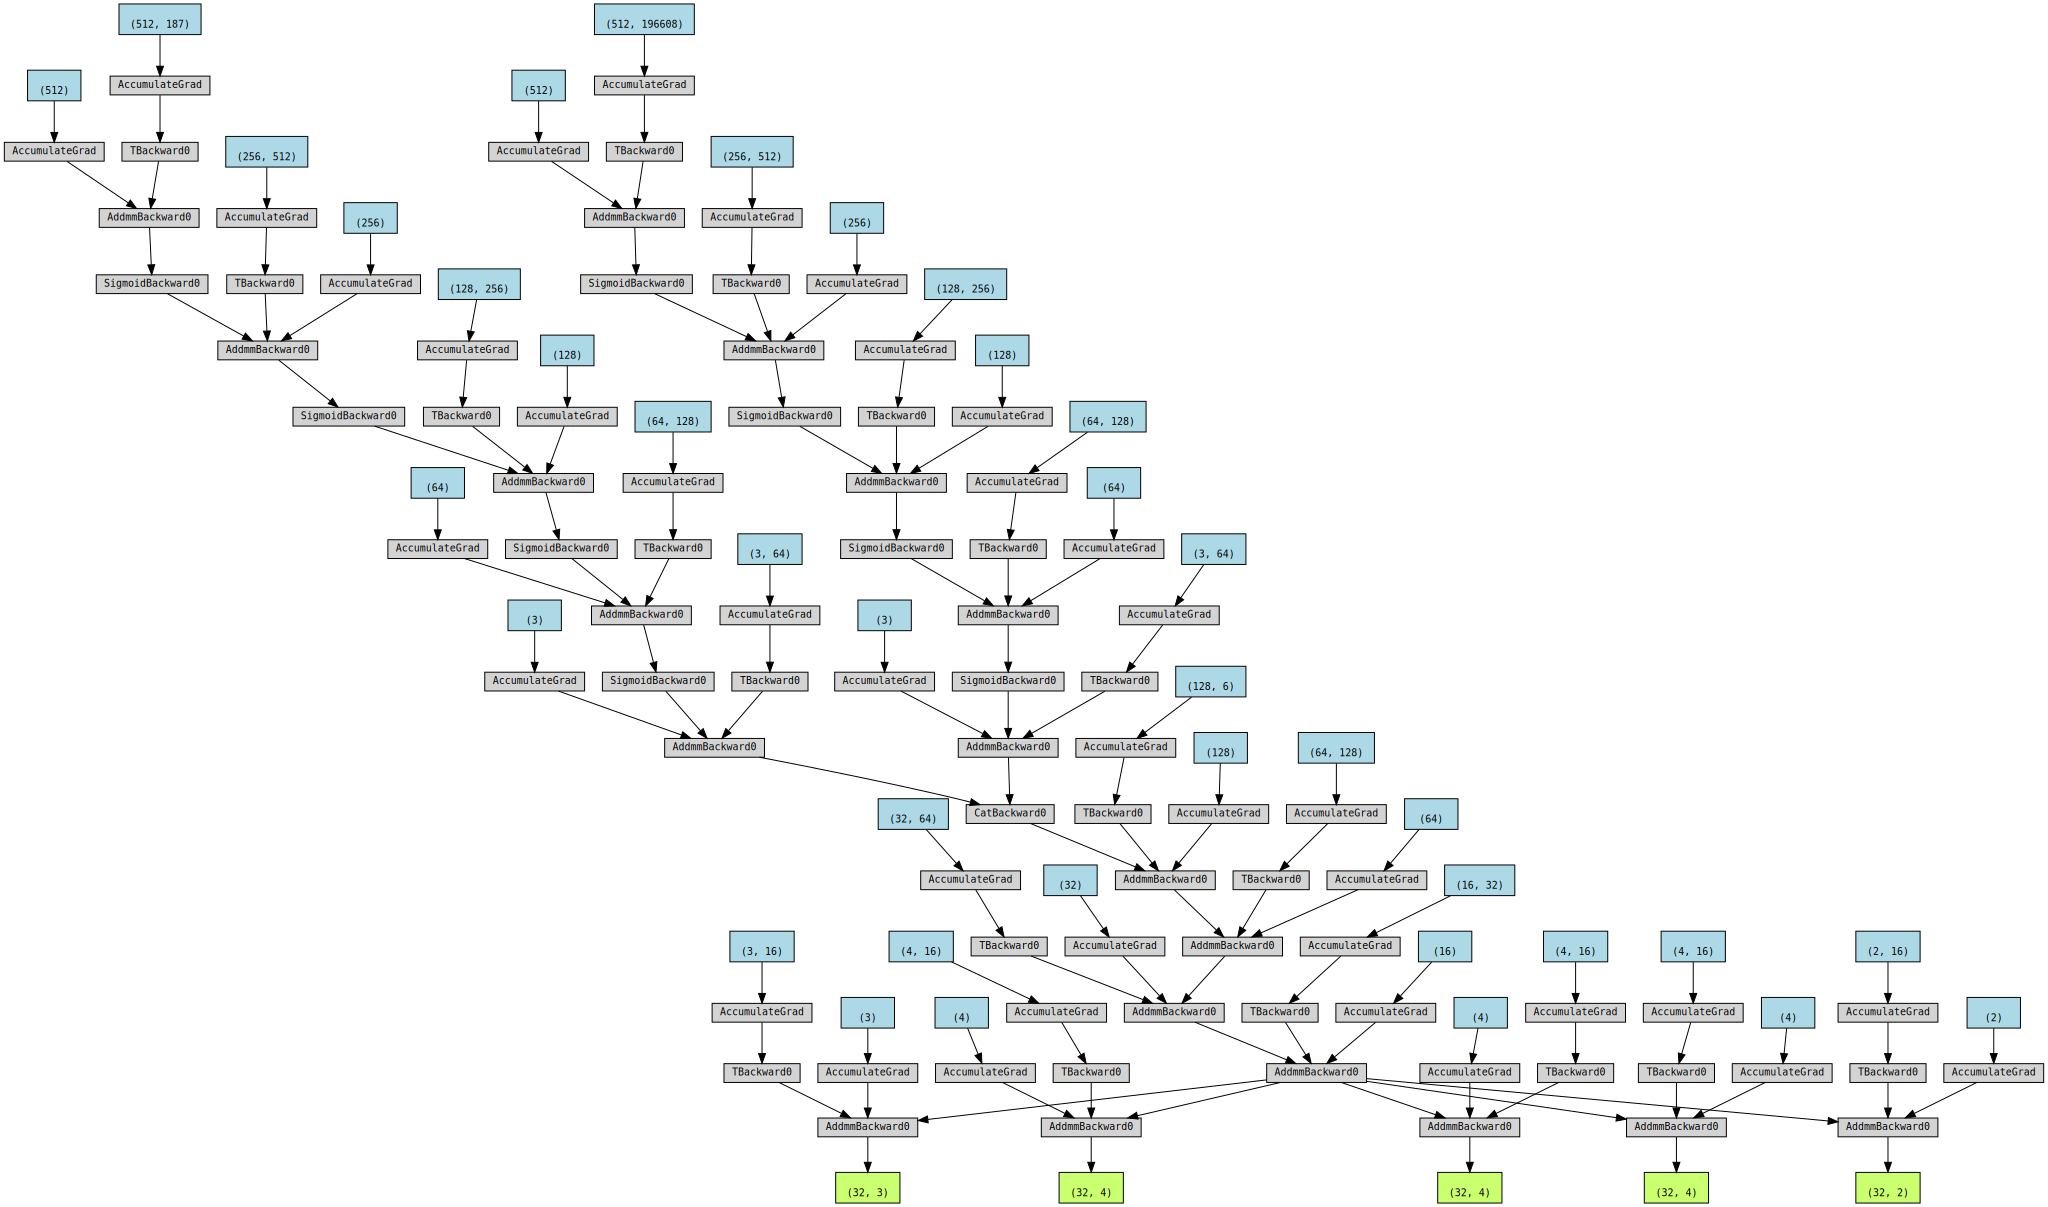

In [ ]:
network = next(iter(train_loader))
graph = combined_model(network[0].to(device), network[1].to(device))
make_dot(graph)